In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

In [2]:
moonshot_file = "../../covid_submissions_all_info.csv"
df = pd.read_csv(moonshot_file)
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
[10:06:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:06:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:06

In [3]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdchem

def GetTrueScaffold(mol,generic=False):
    #Not sure if hybridisation of dummy atom is correct
    #Not sure on properties
    #Seems to work as desired
    """
    Takes RDKit mol object
    Returns mol object of the murcko scaffold with original algorithm
    Stereochemistry is lost
    """
    mol = MurckoScaffold.GetScaffoldForMol(mol)
    atom_to_remove = []
    atom_to_clean = []
    
    for a in mol.GetAtoms():
        #Remove chirality
        mol.GetAtomWithIdx(a.GetIdx()).SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        
        #For atoms bonded to only one other atom, these must be removed
        if len(a.GetBonds()) == 1:
            #Get index of atom to delete and append to deletion list
            atom_to_remove.append(a.GetIdx())

    #If there are atoms to delte
    if len(atom_to_remove) > 0:
        #Create an editable molecule (now RW)
        emol = rdchem.RWMol(mol)
        #Every time an atom is delted the index changes
        #Deletion list must be reversed to avoid rogue deletions
        for a in atom_to_remove[::-1]:
            #Remove atom by index a
            emol.RemoveAtom(a)
    #If the molecule is already the correct murcko scaffold set emol = mol
    else:
        emol = mol
    
    #This line used to cause errors
    #SanitizeMol(emol) often failed due to aromaticity
    #Attempts to solve this included replacing previously bonded atoms with the
    #wild card *
    #It seems clearing aromatic flags solved the issue
    try:
        #Clearing aromatic flags seems to fix everything
        Chem.Kekulize(emol,clearAromaticFlags=True)
        Chem.SanitizeMol(emol)
    except:
        #Error
        #Will show the input molecule and attempted editted molecule (before sanitization attempt)
        display("Input Mol")
        display(mol)
        display("Output Emol")
        display(emol)
        raise ("Error in santisation of new molecule")
        return False
    
    #The above procedure will remove all remaining decorating groups on scaffold
    #In some cases (like sulfonyl) this will leave an aliphatic chain
    #Additional application of MurckoScaffold algorithm is needed
    #However the RDKit implementation is sufficient 
    emol = MurckoScaffold.GetScaffoldForMol(emol)
    
    #If the generic scaffold is desired (Flag), make generic
    if generic:
        emol = MurckoScaffold.MakeScaffoldGeneric(emol)

    #Return the molecule
    return emol

In [4]:
mol_cluster = ['MAK-UNK-af83ef51-6',
 'PAU-UNI-8cdd41c7-1',
 'NEH-REV-107bcf72-5',
 'MED-COV-4280ac29-13',
 'LON-WEI-8f408cad-2',
 'NIR-THE-0d6461ce-8',
 'DAR-DIA-fb20be43-4',
 'MED-COV-4280ac29-33',
 'MIH-UNI-e573136b-5',
 'DAN-LON-a5fc619e-3',
 'GIA-UNK-a79af1bc-1',
 'BRU-LEF-ae0885ba-1',
 'WAR-XCH-79d12f6e-6',
 'LON-WEI-8f408cad-4',
 'MED-COV-4280ac29-15',
 'PAU-UNI-52c0427f-1',
 'MED-COV-4280ac29-37']



"""
mol_cluster = ['NEH-REV-107bcf72-5',
 'PAU-UNI-8cdd41c7-1',
 'MED-COV-4280ac29-13',
 'MED-COV-4280ac29-33',
 'MIH-UNI-e573136b-5',
 'DAN-LON-a5fc619e-3',
 'MED-COV-4280ac29-15',
 'MED-COV-4280ac29-37']
"""

"\nmol_cluster = ['NEH-REV-107bcf72-5',\n 'PAU-UNI-8cdd41c7-1',\n 'MED-COV-4280ac29-13',\n 'MED-COV-4280ac29-33',\n 'MIH-UNI-e573136b-5',\n 'DAN-LON-a5fc619e-3',\n 'MED-COV-4280ac29-15',\n 'MED-COV-4280ac29-37']\n"

In [5]:
res = df.loc[df["CID"].isin(mol_cluster)]
res = res[["CID", "Molecule"]]

In [6]:
mol_cluster = []
with open("largest_generic_scaffold.csv","r") as readfile:
    for line in readfile.readlines():
        mol_cluster.append(line.strip())

In [7]:
res = df.loc[df["CID"].isin(mol_cluster)]
res = res[["CID", "Molecule"]]

In [8]:
from rdkit.Chem import ReplaceCore

def GetFragments(mol, core):
    fragments = ReplaceCore(mol,
                            core,
                            labelByIndex=True
                           )
    return fragments

In [9]:
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.rdFMCS import AtomCompare
from rdkit.Chem.rdFMCS import RingCompare
from rdkit.Chem.rdFMCS import BondCompare

In [10]:
mols = list(res["Molecule"])
#scaffolds = [GetTrueScaffold(x) for x in mols]


c = FindMCS(mols, 
            atomCompare=AtomCompare.CompareAny,
            ringCompare=RingCompare.IgnoreRingFusion,
            bondCompare=BondCompare.CompareAny,
            #completeRingsOnly=True
            #threshold=0.8,#Much slower
           )


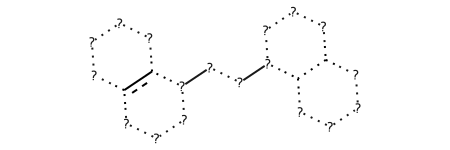

In [11]:
core = Chem.MolFromSmarts(c.smartsString)
core

In [12]:
res["fragments"] = res.apply(lambda x: GetFragments(x["Molecule"], core), axis = 1)

In [13]:
#show_df(res.head(10))

In [14]:
random_mols_1 = res.iloc[10:20]
random_mols_2 = res.iloc[20:30]


frag_df = random_mols_1[["Molecule","fragments"]]
frag_df["Molecule2"] = list(random_mols_2["Molecule"])
frag_df["fragments2"] = list(random_mols_2["fragments"])

,fragments,fragments2
13662,,
13663,,
13664,,
13665,,
13668,,

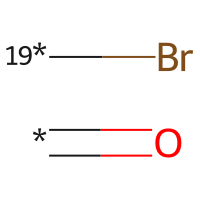
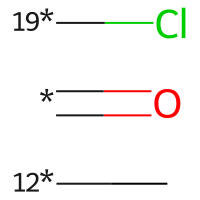
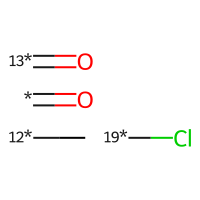
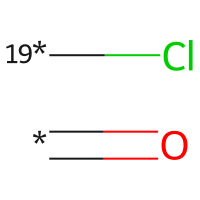
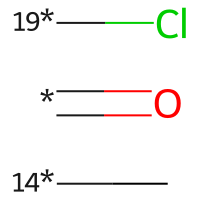
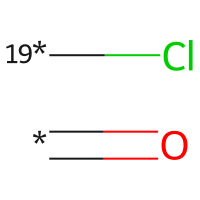
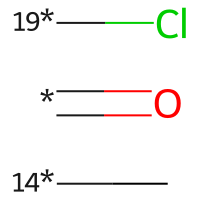
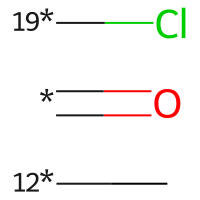
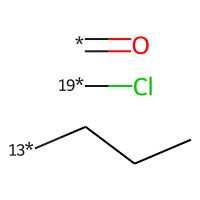
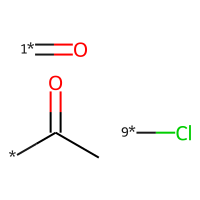

In [15]:
show_df(frag_df[["fragments","fragments2"]].head())

In [16]:
from rdkit.Chem.rdMolHash import MolHash
from rdkit.Chem.rdMolHash import HashFunction

In [17]:
def UniqueFragments(frags1,frags2):
    """
    input are mol
    """
    frags1=Chem.GetMolFrags(frags1, asMols=True)
    frags2=Chem.GetMolFrags(frags2, asMols=True)
    
    hash1 = [MolHash(x,HashFunction.CanonicalSmiles) for x in frags1]
    hash2 = [MolHash(x,HashFunction.CanonicalSmiles) for x in frags2]
    
    hash1 = set(hash1)
    hash2 = set(hash2)
    
    unique = (hash1-hash2).union(hash2-hash1)
    
    return(list(unique))

In [18]:
frag_df["diff_frags"] = frag_df.apply(lambda x: UniqueFragments(x["fragments"],x["fragments2"]), axis = 1)

,fragments,fragments2,diff_frags
13662,,,"[[12*]C, [19*]Cl, [19*]Br]"
13663,,,"[[13*]=O, [12*]C]"
13664,,,[[14*]C]
13665,,,"[[12*]C, [14*]C]"
13668,,,"[[13*]CCC, *=O, [19*]Cl, *C(C)=O, [9*]Cl, [1*]=O]"

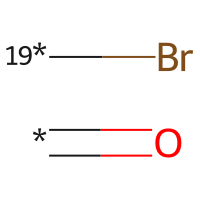
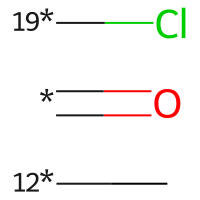
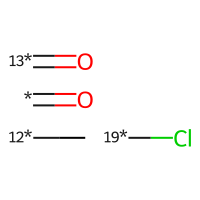
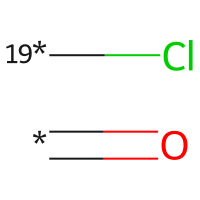
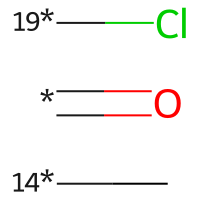
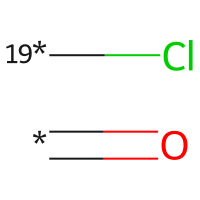
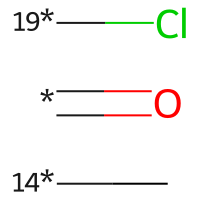
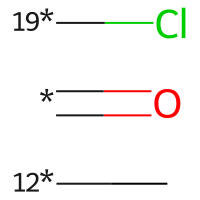
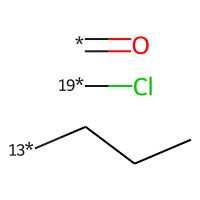
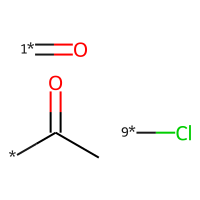

In [19]:
show_df(frag_df[["fragments","fragments2","diff_frags"]].head())

In [20]:
def GetFragmentsFromPair(mol1,mol2,seed):
    
    mcs = FindMCS([mol1, mol2],
                     timeout=1,
                     ringMatchesRingOnly=True,
                     completeRingsOnly=True,
                     seedSmarts=seed,
                      #atomCompare=AtomCompare.CompareAnyHeavyAtom,
                      #ringCompare=RingCompare.IgnoreRingFusion,
                      bondCompare=BondCompare.CompareAny,
                    )
    mcs = Chem.MolFromSmarts(mcs.smartsString)
    
    frags1 = ReplaceCore(mol1,mcs,labelByIndex=True)
    frags2 = ReplaceCore(mol2,mcs,labelByIndex=True)
     
    return frags1,frags2

,Molecule,fragments,Molecule2,fragments2,diff_frags
13662,,,,,"[[12*]C, [19*]Cl, [19*]Br]"
13663,,,,,"[[13*]=O, [12*]C]"
13664,,,,,[[14*]C]
13665,,,,,"[[12*]C, [14*]C]"
13668,,,,,"[[13*]CCC, *=O, [19*]Cl, *C(C)=O, [9*]Cl, [1*]=O]"

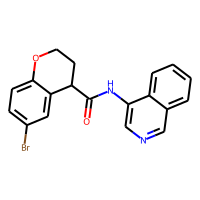
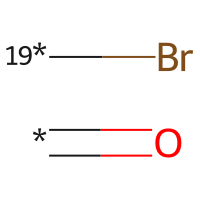
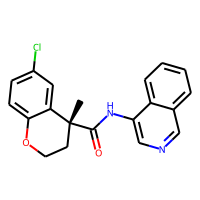
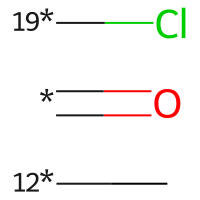
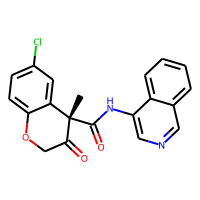
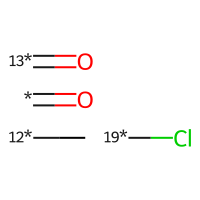
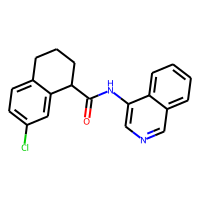
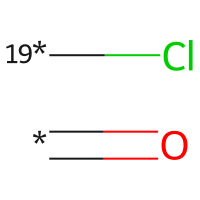
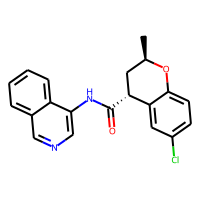
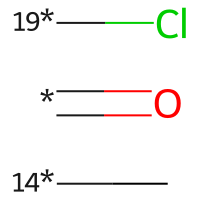
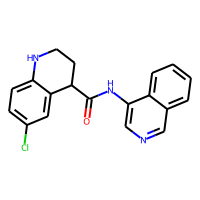
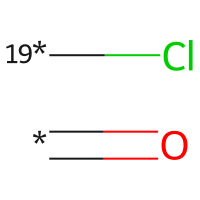
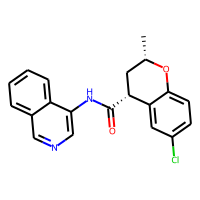
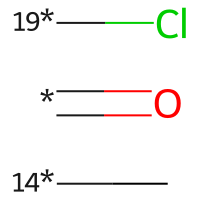
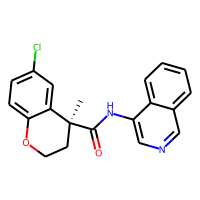
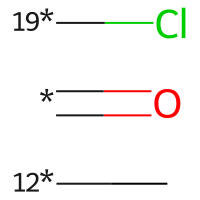
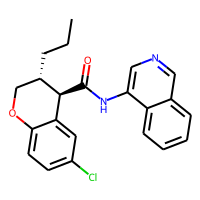
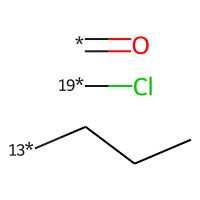
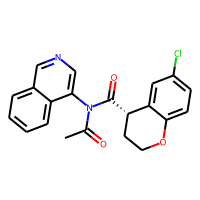
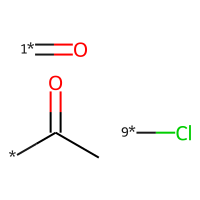

In [21]:
show_df(frag_df.head())

In [22]:
#New fragment finder, with seeded MCS
seed = c.smartsString
#frag_df["from_mcs1"] = frag_df.apply(lambda x: GetFragmentsFromPair1(x["Molecule"],x["Molecule2"], seed), axis = 1)
#frag_df["from_mcs2"] = frag_df.apply(lambda x: GetFragmentsFromPair2(x["Molecule"],x["Molecule2"], seed), axis = 1)

In [23]:
#To solve issue of missed transformations
#Convert entire core backbone identified by seed mcs to carbon
#Then do mcs matching by atom identity

,Molecule,Molecule2,fragments,fragments2,from_mcs1,from_mcs2
13662,,,,,,
13663,,,,,,
13664,,,,,,
13665,,,,,,
13668,,,,,,
13669,,,,,,
13670,,,,,,
13671,,,,,,
13672,,,,,,
13673,,,,,,

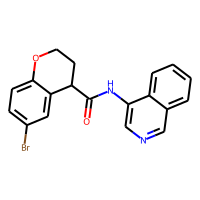
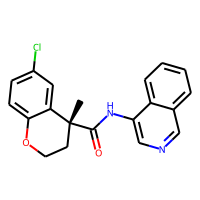
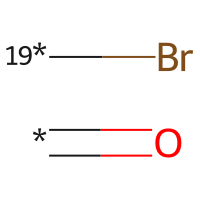
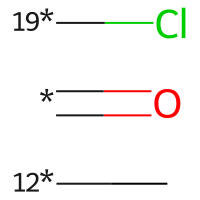
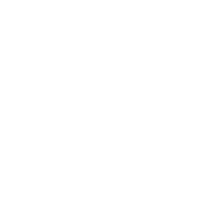
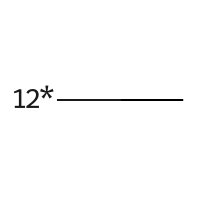
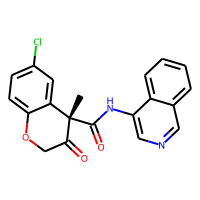
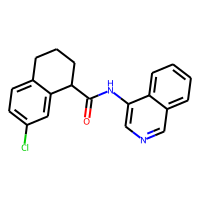
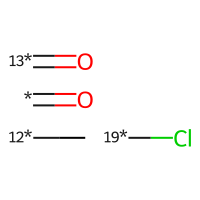
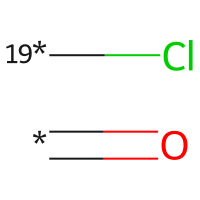
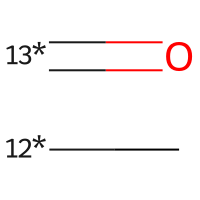
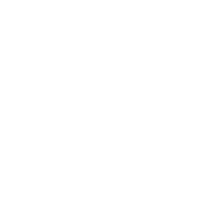
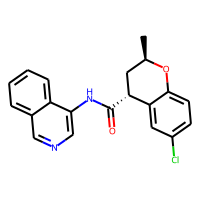
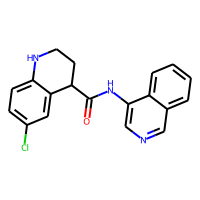
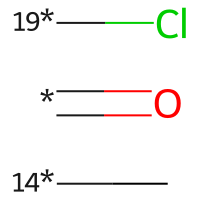
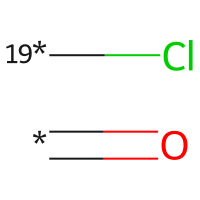
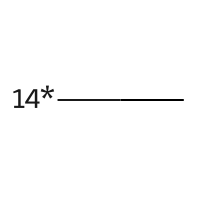
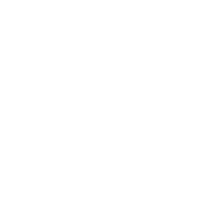
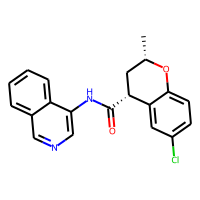
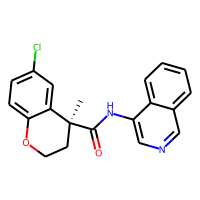
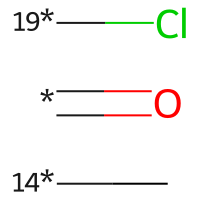
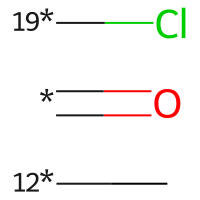
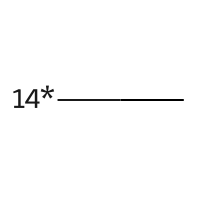
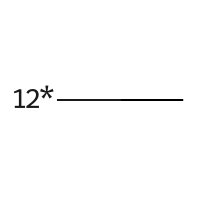
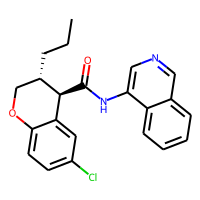
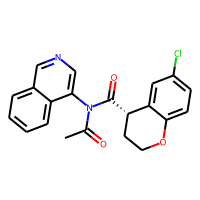
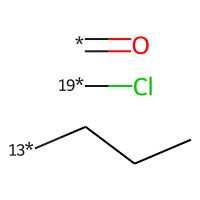
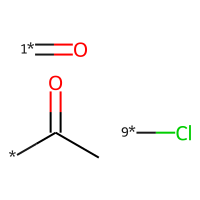
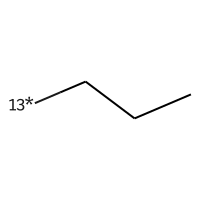
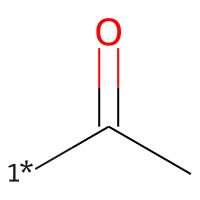
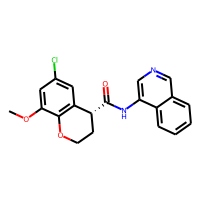
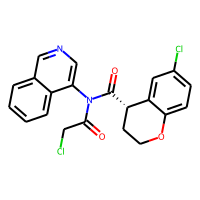
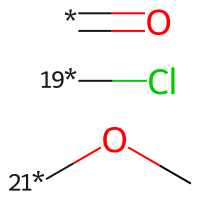
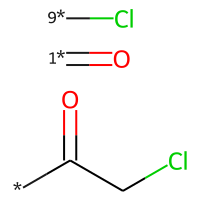
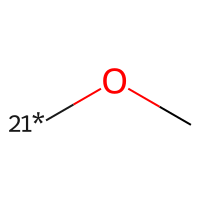
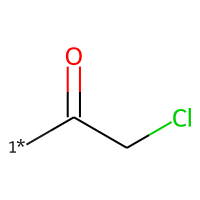
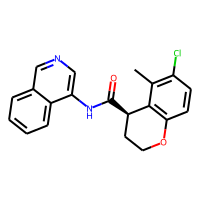
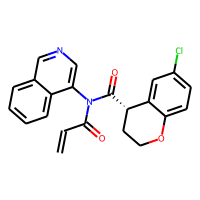
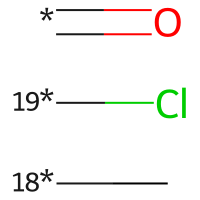
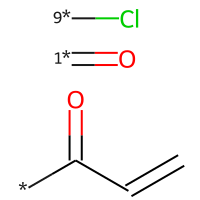
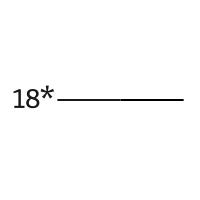
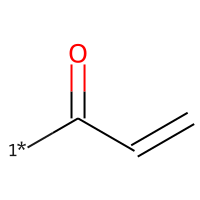
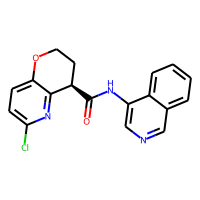
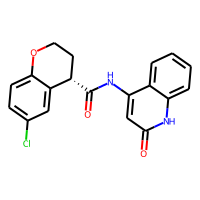
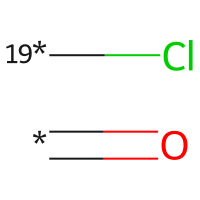
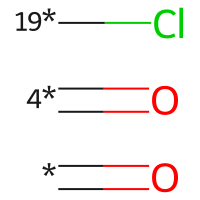
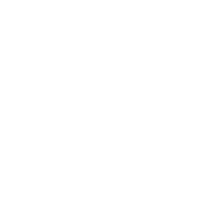
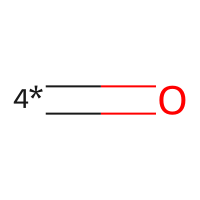
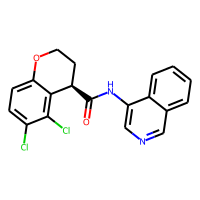
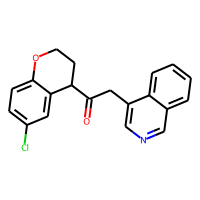
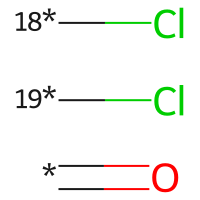
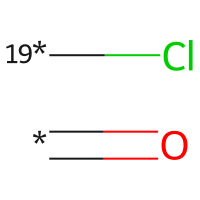
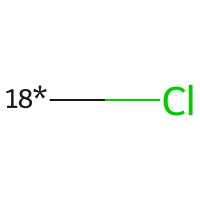
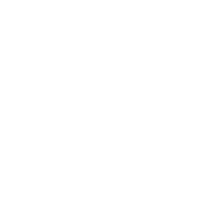
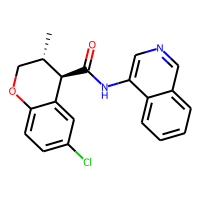
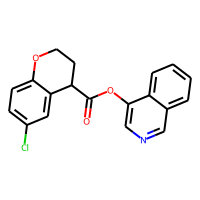
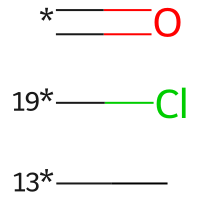
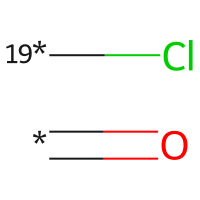
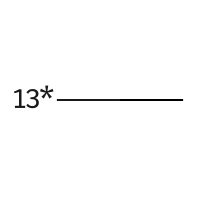
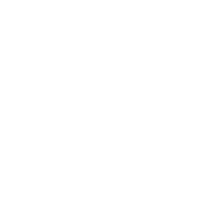

In [24]:
show_df(frag_df[["Molecule","Molecule2","fragments","fragments2","from_mcs1","from_mcs2"]])

,Molecule,fragments,Molecule2,fragments2,diff_frags,from_mcs1,from_mcs2
13662,,,,,"[[12*]C, [19*]Cl, [19*]Br]",,
13663,,,,,"[[13*]=O, [12*]C]",,
13664,,,,,[[14*]C],,
13665,,,,,"[[12*]C, [14*]C]",,
13668,,,,,"[[13*]CCC, *=O, [19*]Cl, *C(C)=O, [9*]Cl, [1*]=O]",,

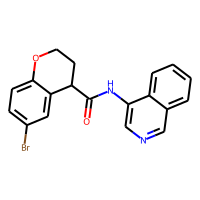
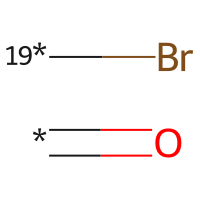
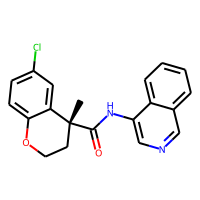
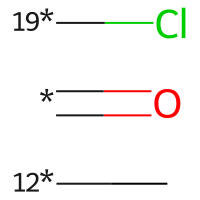
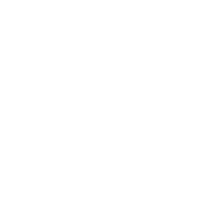
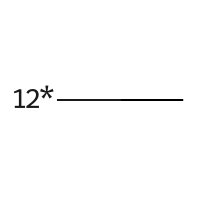
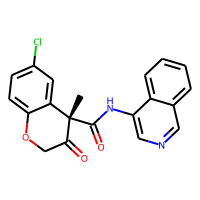
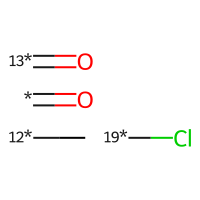
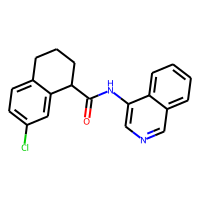
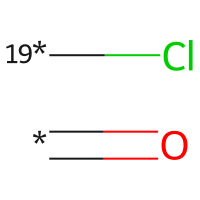
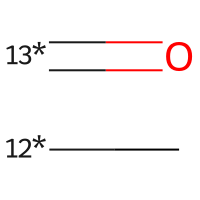
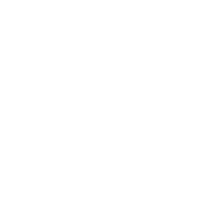
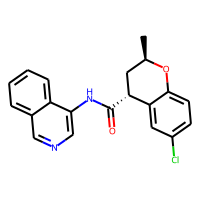
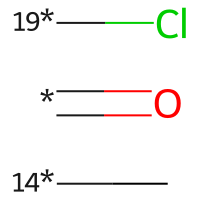
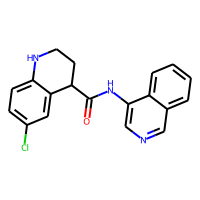
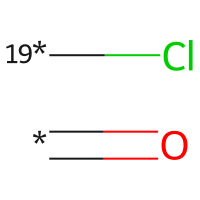
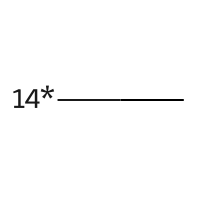
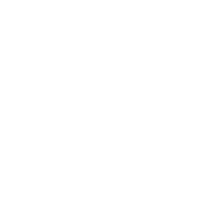
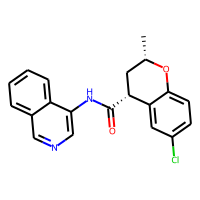
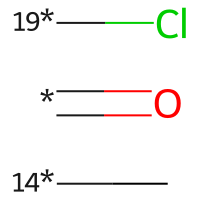
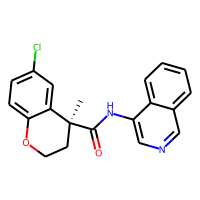
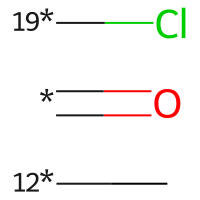
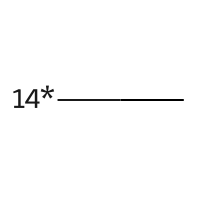
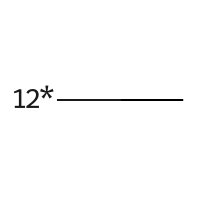
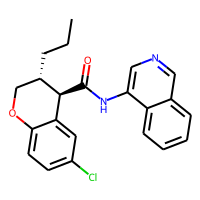
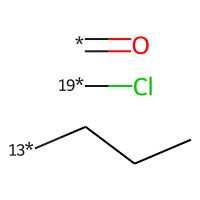
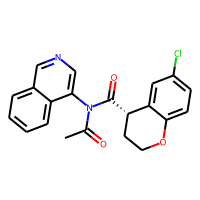
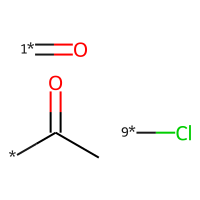
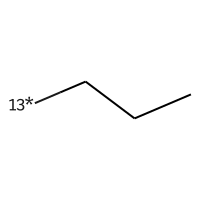
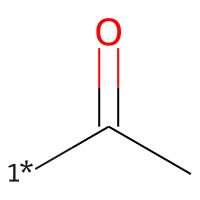

In [25]:
show_df(frag_df.head())

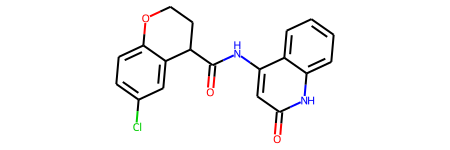

In [26]:
mols[0]

In [27]:
seed = c.smartsString
frags1, frags2 = GetFragmentsFromPair(mols[3],mols[1],seed)

NameError: name 'GetFragmentsFromPair' is not defined

In [ ]:
display(mols[3])
display(mols[1])

In [ ]:
frags2

In [ ]:
n=200
mols_subset = mols[:n]
print((n*n-n)/2)

In [ ]:
import time

In [ ]:
t1 = time.time()
mcs_array_1 = []
for i in range(len(mols_subset)):
    for j in range(i):
        mol1 = mols_subset[i]
        mol2 = mols_subset[j]
        
        mcs = FindMCS([mol1, mol2],
                     timeout=1,
                     ringMatchesRingOnly=True,
                     completeRingsOnly=True,
                     seedSmarts=c.smartsString,
                      atomCompare=AtomCompare.CompareAny,
                      #ringCompare=RingCompare.IgnoreRingFusion,
                      bondCompare=BondCompare.CompareAny,
                    )
        mcs_array_1.append(mcs)
t2 = time.time()
print(round(t2-t1, 3), "seconds")

In [ ]:
for i in range(20):
    display(Chem.MolFromSmarts(mcs_array_1[i].smartsString))

In [ ]:
t3 = time.time()
mcs_array_2 = []
for i in range(len(mols_subset)):
    for j in range(i):
        mol1 = mols_subset[i]
        mol2 = mols_subset[j]
        
        mcs = FindMCS([mol1, mol2],
                     timeout=1,
                     ringMatchesRingOnly=True,
                     completeRingsOnly=True,
                     #seedSmarts=c.smartsString,
                      atomCompare=AtomCompare.CompareAny,
                      #ringCompare=RingCompare.IgnoreRingFusion,
                      bondCompare=BondCompare.CompareAny,
                    )
        mcs_array_2.append(mcs)
t4 = time.time()
print(round(t4-t3, 3), "seconds")

In [ ]:
print((t2-t1)/(t4-t3))

In [ ]:
print((t4-t3)/(t2-t1))

In [ ]:
Chem.MolFromSmarts(c.smartsString)

In [ ]:
"""
for a,b in zip(mcs_array_1,mcs_array_2):
    a = Chem.MolFromSmarts(a.smartsString)
    b = Chem.MolFromSmarts(b.smartsString)
    display("1",a)
    display("2",b)
"""

In [35]:
seed

'[#6,#7,#16](-,=[#6,#7,#8,#16]-[#6,#7]1-,=,:[#6,#7]-,:[#6,#7,#8,#16]-,:[#8,#6,#7,#16]-,:[#6]2:,-[#6]-,:1:,-[#6,#7]:,-,=[#6,#7,#8,#16]:,-[#6,#7,#8,#16]:,-,=[#6,#7]:,-2)-[#7,#6]1-,=,:[#6,#7,#8,#16]-,:[#6,#7,#8,#16]-,=,:[#16,#6,#7,#8]-,:[#6]2:[#6]-,:1:,-[#6,#7]:,-[#6,#7,#8]:,-[#6,#7]:,-[#7,#6]:,-2'

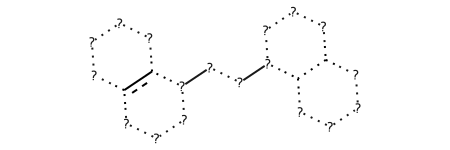

In [36]:
Chem.MolFromSmarts(seed)

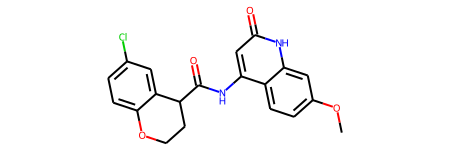

In [34]:
mols[1]

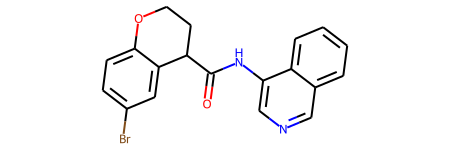

In [33]:
mols[10]

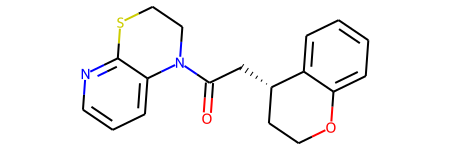

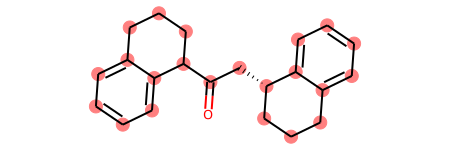

In [48]:
#### Make generic backbone
seed_mol = Chem.MolFromSmarts(seed)
test_mol = mols[2]
display(test_mol)
for idx in test_mol.GetSubstructMatch(Chem.MolFromSmarts(seed)):
    test_mol.GetAtomWithIdx(idx).SetAtomicNum(6)
display(test_mol)

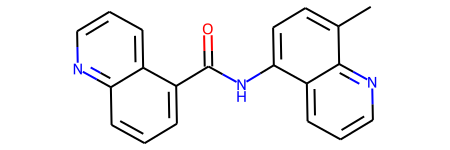

In [56]:
test_mol = mols[3]
test_mol

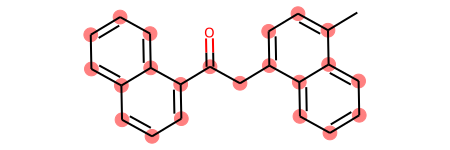

In [57]:
CleanScaffold(test_mol)

In [52]:
CleanScaffold("test", core="1")

In [44]:
atom_match = mols[1].GetSubstructMatch(Chem.MolFromSmarts(seed))

In [45]:
test_mol = mols[1]

In [46]:
test_mol.GetAtomWithIdx(7).SetAtomicNum(6)

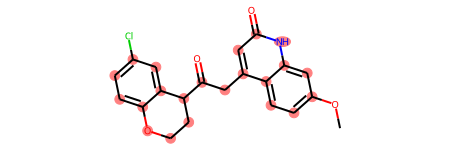

In [47]:
test_mol

In [ ]:
SetAtomicNum(7)

In [42]:
atom_match

(7,
 8,
 10,
 11,
 12,
 13,
 14,
 20,
 19,
 17,
 16,
 15,
 6,
 21,
 22,
 24,
 25,
 5,
 4,
 3,
 2,
 26)

In [ ]:
def CleanScaffold(mol,core=None):
    if not core:
        core = GetTrueScaffold(mol)
    for atom_idx in mol.GetSubstructMatch(core):
        mol.GetAtomWithIdx(atom_idx).SetAtomicNum(6)
    return mol